In [1]:
# The code was removed by Watson Studio for sharing.

# NY State / COVID Project

## Part 1: Data acquisition

In [2]:
#Importing the tools that will be necessary in this project

#DataFrame Library
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)

#Numerical analysis Library
import numpy as np #

#Matplotlib for simple data visualization
import matplotlib.pyplot as plt
%matplotlib inline

#Seaborn for correlation plots
import seaborn as sns

#Request management Library
import requests

#Sodapy to handle API queries to the NY GOV database
! pip install sodapy
from sodapy import Socrata

#Obtain the current date
from datetime import date, timedelta

#Insert Project Handling Library for critical DF backups
from project_lib import Project

In [3]:
#Importing COVID testing data through Socrata and save it in DF results_df

client = Socrata("health.data.ny.gov", None)

# Example authenticated client (needed for non-public datasets):
# client = Socrata(health.data.ny.gov,
#                  MyAppToken,
#                  userame="user@example.com",
#                  password="AFakePassword")

# First 2000 results, returned as JSON from API / converted to Python list of
# dictionaries by sodapy.
results = client.get("xdss-u53e")

# Convert to pandas DataFrame
results_df = pd.DataFrame.from_records(results)

In [4]:
#BackUp as CSV to Project
project.save_data("NY_COVID_DATA.csv", results_df.to_csv(index=False))

2020-04-11 21:24:21,622 - __PROJECT_LIB__ - ERROR - Project__save_data(): failed to save data! File 'NY_COVID_DATA.csv' already exists in storage! Set the optional parameter 'overwrite' to True if you want to overwrite.
ERROR:__PROJECT_LIB__:Project__save_data(): failed to save data! File 'NY_COVID_DATA.csv' already exists in storage! Set the optional parameter 'overwrite' to True if you want to overwrite.


RuntimeError: Project__save_data(): failed to save data! File 'NY_COVID_DATA.csv' already exists in storage! Set the optional parameter 'overwrite' to True if you want to overwrite.

In [4]:
#We will also need population data by county. Let's import that data now

pop_results = client.get("e9uj-s3sf")
population_df = pd.DataFrame.from_records(pop_results)

In [49]:
#BackUp as CSV to Project
project.save_data("NCOUNTY_POPULATION.csv", population_df.to_csv(index=False))

{'file_name': 'NCOUNTY_POPULATION.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'learningproject-donotdelete-pr-ivxdtjkpbb2hvo',
 'asset_id': '12c3313d-3fab-4ba1-8c2b-70039749db75'}

In [5]:
results_df.head() #Checkpoint

,county,cumulative_number_of_positives,cumulative_number_of_tests,new_positives,test_date,total_number_of_tests
0,Albany,446,5124,20,2020-04-10T00:00:00.000,159
1,Allegany,26,264,0,2020-04-10T00:00:00.000,16
2,Bronx,20477,39494,1317,2020-04-10T00:00:00.000,2580
3,Broome,117,849,5,2020-04-10T00:00:00.000,31
4,Cattaraugus,19,332,1,2020-04-10T00:00:00.000,7


Now that we have obtained the covid raw data, we can create a new DF with only the columns that will be relevant to us: county, cumulative_number_of_positives, and cumulative_number_of_tests. We also want to drop data from previous days and keep only the cumulative data for today.

In [6]:
#Creating a new DF with the data that will be necessary for analysis

COVID_raw_df = results_df.copy() #Creates a new DF 'COVID_raw_df' that stores only the results relevant to our analysis, i.e. cumulative data
COVID_raw_df = COVID_raw_df[COVID_raw_df['test_date'] == (str(date.today()-timedelta(days=2))+'T00:00:00.000')] #Keep only the current results, by cutting off all results before the day before.
COVID_raw_df.drop(['new_positives', 'test_date', 'total_number_of_tests'], axis=1, inplace=True) #Drop unecessary columns
COVID_raw_df.rename(columns={"county": "County", "cumulative_number_of_positives": "Positives", "cumulative_number_of_tests":"Tests"}, inplace=True) #Rename columns for labels that are easier to use
COVID_raw_df.head() #Checkpoint

,County,Positives,Tests
0,Albany,446,5124
1,Allegany,26,264
2,Bronx,20477,39494
3,Broome,117,849
4,Cattaraugus,19,332


In [7]:
#Verifying data integrity

#Checking for the presence of null results
print(COVID_raw_df.isnull().sum())

#Checking for duplicated counties
print("\nThe number of duplicates is: {}".format(COVID_raw_df.duplicated('County', keep=False).sum()))

County       0
Positives    0
Tests        0
dtype: int64

The number of duplicates is: 0


We also need to incorporate population data per county in our analysis. Let's have a look at our population DF:

In [8]:
#Looking at the population DF

population_df.head()

,age_group_code,age_group_description,county_code,county_name,gender_code,gender_description,population,race_ethnicity,race_ethnicity_code,year
0,0,Total,1,New York State,0,Total,19849399,Total,0,2017
1,0,Total,2,New York City,0,Total,8622698,Total,0,2017
2,0,Total,3,Bronx,0,Total,1471160,Total,0,2017
3,0,Total,4,Kings,0,Total,2648771,Total,0,2017
4,0,Total,5,New York,0,Total,1664727,Total,0,2017


From that DF, we only need the counties names and the population. We are also only interested in the latest data, so let's exclude all data that is not from 2017:

In [9]:
#Creating a new DF 'pop_df' that will host only population data relevant to us

pop_df = population_df.copy() #Initialize the DF that will hold population data
pop_df = pop_df[(pop_df['year'] == '2017') & (pop_df['race_ethnicity'] == 'Total') & (pop_df['gender_description'] == 'Total') & (pop_df['age_group_description'] == 'Total')] #Keep only data pertaining the current data and the total of the population
pop_df = pop_df[['county_name', 'population']] #Keep only the counties and the population columns
pop_df.rename(columns={"county_name": "County", "population": "Population"}, inplace=True) #Rename the column labels
pop_df.at[pop_df.index[pop_df['County'] == 'St Lawrence'][0], 'County'] = 'St. Lawrence'
pop_df.head() #Checkpoint

,County,Population
0,New York State,19849399
1,New York City,8622698
2,Bronx,1471160
3,Kings,2648771
4,New York,1664727


Let's compare the shape of the COVID and Population DF to make sure they are compatible:

In [10]:
#Checking DF shapes. The number of rows should be the same

print(COVID_raw_df.shape)
print(pop_df.shape)

(62, 3)
(65, 2)


The population DF has additional entris for the whole state, NYC and the rest of the test. We will drop those entries in the next step:

In [11]:
#Joining the COVID and Population tables

COVID_pop_df = COVID_raw_df.merge(pop_df, how='inner', sort=False) #Join the two tables, keeping only those entries that are common between the two DF
COVID_pop_df=COVID_pop_df[['County', 'Population', 'Positives', 'Tests']] #Reorder the columns so population is next to county name
COVID_pop_df.head() #Checkpoint

,County,Population,Positives,Tests
0,Albany,309612,446,5124
1,Allegany,46894,26,264
2,Bronx,1471160,20477,39494
3,Broome,193639,117,849
4,Cattaraugus,77348,19,332


Now that we have our DF, we can obtain some simple metrics and add it to the table:

In [12]:
#Typesetting items on the table to Int

COVID_pop_df[['Population', 'Positives', 'Tests']] = COVID_pop_df[['Population', 'Positives', 'Tests']].astype('int')

COVID_pop_df.dtypes

County        object
Population     int64
Positives      int64
Tests          int64
dtype: object

In [13]:
#Adding new columns to the DF

COVID_pop_df['Positive/Population'] = ((COVID_pop_df['Positives']/COVID_pop_df['Population'])*100000).astype('float')
COVID_pop_df['Tests/Population'] = ((COVID_pop_df['Tests']/COVID_pop_df['Population'])*100000).astype('float')
COVID_pop_df['Positive/Tests'] = (COVID_pop_df['Positives']/COVID_pop_df['Tests']).astype('float')

COVID_pop_df.head() #Checkpoint

,County,Population,Positives,Tests,Positive/Population,Tests/Population,Positive/Tests
0,Albany,309612,446,5124,144.051264,1654.974613,0.087041
1,Allegany,46894,26,264,55.444193,562.971809,0.098485
2,Bronx,1471160,20477,39494,1391.894831,2684.548248,0.518484
3,Broome,193639,117,849,60.421713,438.444735,0.137809
4,Cattaraugus,77348,19,332,24.564307,429.228939,0.057229


Let's have a first look at the data:

<Figure size 7200x720 with 0 Axes>

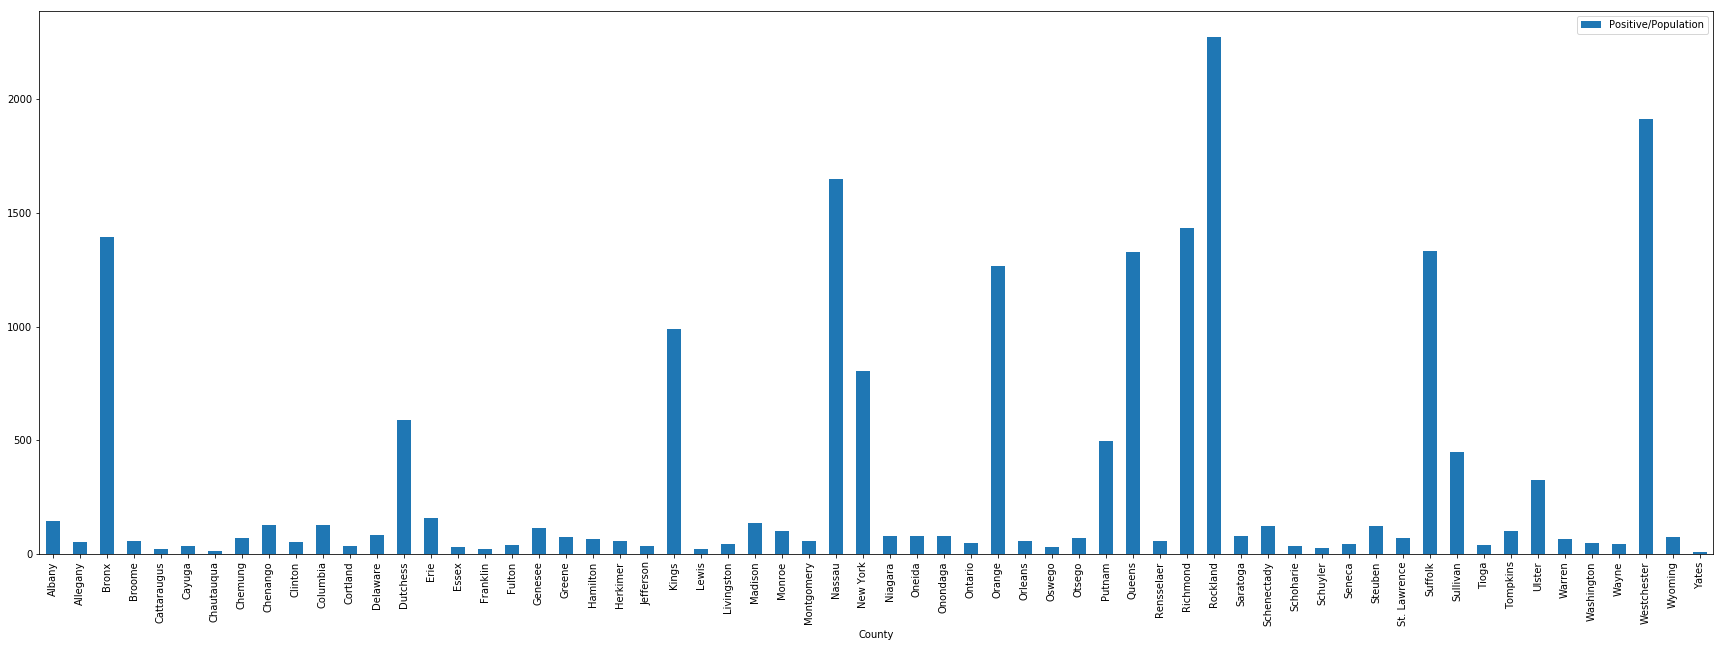

In [14]:
figure1 = plt.figure(figsize=(100,10), clear=True)

COVID_pop_df.plot(kind='bar', x='County', y='Positive/Population')
plt.gcf().set_size_inches(30, 10)

figure1.show()

<Figure size 7200x720 with 0 Axes>

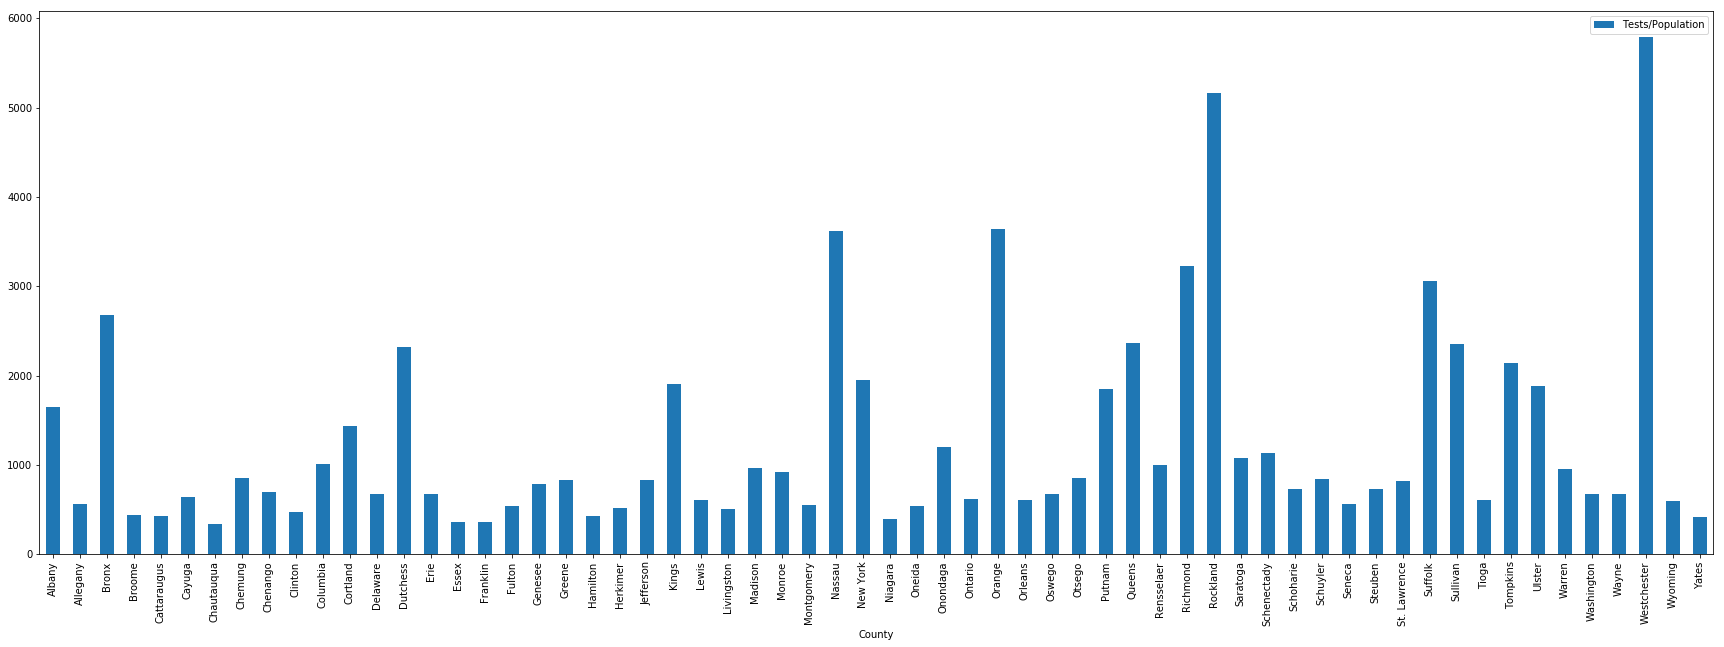

In [15]:
figure2 = plt.figure(figsize=(100,10), clear=True)

COVID_pop_df.plot(kind='bar', x='County', y='Tests/Population')
plt.gcf().set_size_inches(30, 10)

figure2.show()

<Figure size 7200x720 with 0 Axes>

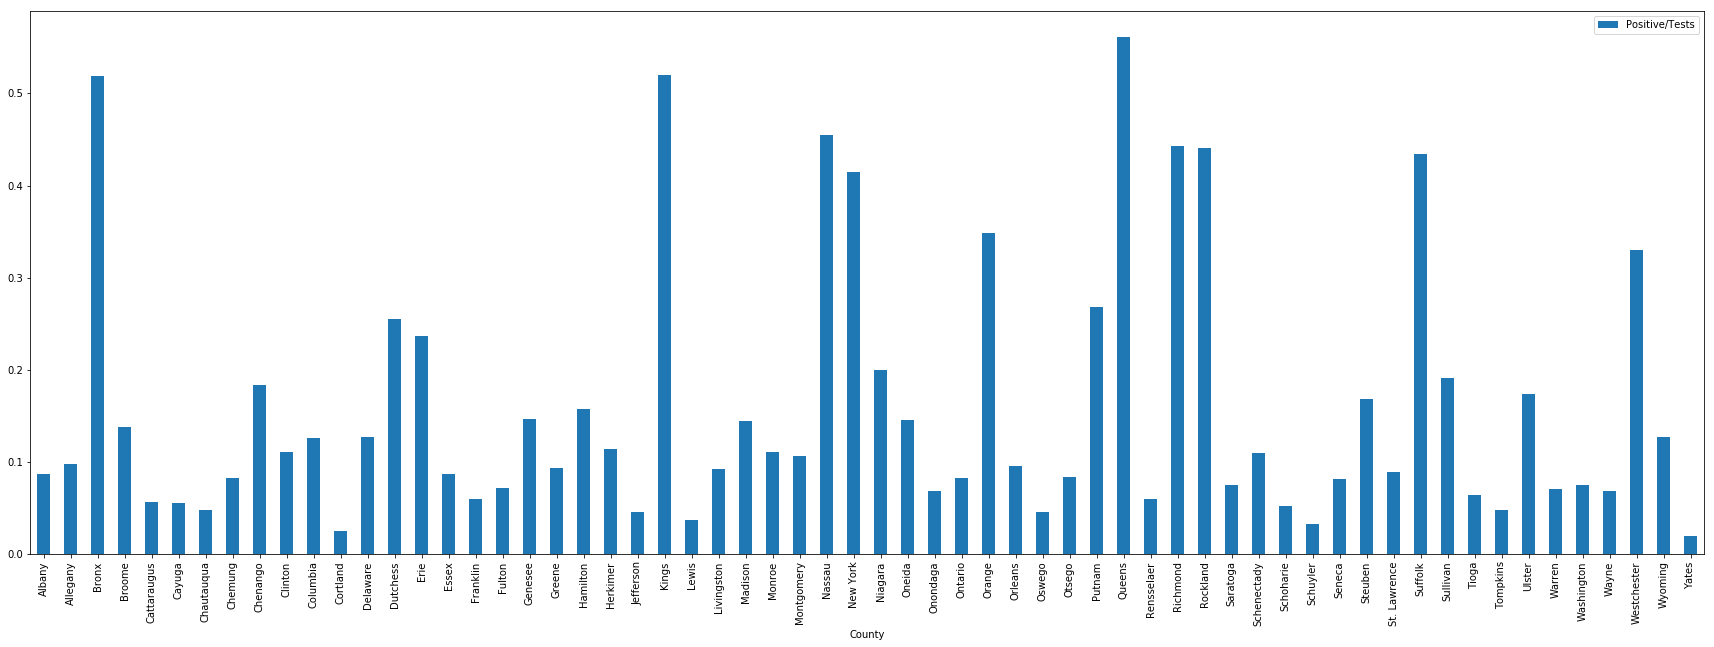

In [16]:
figure3 = plt.figure(figsize=(100,10), clear=True)

COVID_pop_df.plot(kind='bar', x='County', y='Positive/Tests')
plt.gcf().set_size_inches(30, 10)

figure3.show()

As we can see, there is substantial variability between counties. Let's check for correlations before proceeding.

In [17]:
#Drawing a correlation matrix for COVID and population data

COVID_pop_df.corr()

,Population,Positives,Tests,Positive/Population,Tests/Population,Positive/Tests
Population,1.000000,0.934159,0.910812,0.650224,0.493703,0.824209
Positives,0.934159,1.000000,0.980231,0.792630,0.641553,0.868919
Tests,0.910812,0.980231,1.000000,0.831292,0.724840,0.854375
Positive/Population,0.650224,0.792630,0.831292,1.000000,0.933258,0.884496
Tests/Population,0.493703,0.641553,0.724840,0.933258,1.000000,0.726726
Positive/Tests,0.824209,0.868919,0.854375,0.884496,0.726726,1.000000


As one could expect, there is a high correlation between absolute numbers of positives and tests and population, as well as "detection rate", understood here as Positive/Population, with the rate of testing of a county. Particularly relevant for this analysis, however, is the high correlation between the rate of infected, understood here as Positives/Tested, and the population (Pearson score = 0.82). This is problematic for the analysis, because highly populated counties will tend to skew the analysis towards whatever is their clustering type, regardless of the particular clusters compositions. Let's have a look at the distribution of infection rate vs population:

<Figure size 7200x720 with 0 Axes>

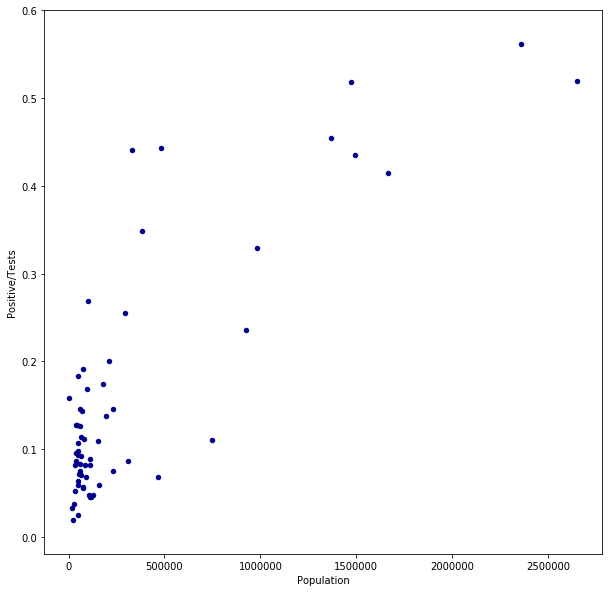

In [18]:
#Scatterplot between Positives/Tests and Population

figure4 = plt.figure(figsize=(100,10), clear=True)

COVID_pop_df.plot.scatter(x='Population',y='Positive/Tests', c='DarkBlue')
plt.gcf().set_size_inches(10, 10)

figure4.show()

Looking at the scatterplot, it looks like there counties can be split in two different groups. Counties with population over 500.000 people appear to have a much closer correlation of infection rate with population size, while counties under 500.000 are less correlated with population size. Let's see if the data corroborates this:

In [19]:
#Splitting the dataset into large and small counties, using 500.000 as an arbitrary cutout

COVID_pop_small = COVID_pop_df[COVID_pop_df['Population'] < 500000]
COVID_pop_large = COVID_pop_df[COVID_pop_df['Population'] > 500000]

In [20]:
COVID_pop_small.corr()

,Population,Positives,Tests,Positive/Population,Tests/Population,Positive/Tests
Population,1.000000,0.685205,0.822688,0.622247,0.643768,0.598677
Positives,0.685205,1.000000,0.962689,0.969430,0.870877,0.851900
Tests,0.822688,0.962689,1.000000,0.935843,0.909294,0.814791
Positive/Population,0.622247,0.969430,0.935843,1.000000,0.926321,0.885080
Tests/Population,0.643768,0.870877,0.909294,0.926321,1.000000,0.774964
Positive/Tests,0.598677,0.851900,0.814791,0.885080,0.774964,1.000000


In [21]:
COVID_pop_large.corr()

,Population,Positives,Tests,Positive/Population,Tests/Population,Positive/Tests
Population,1.000000,0.785501,0.591780,0.254645,-0.068062,0.817227
Positives,0.785501,1.000000,0.935743,0.776858,0.489870,0.922645
Tests,0.591780,0.935743,1.000000,0.916543,0.751035,0.793571
Positive/Population,0.254645,0.776858,0.916543,1.000000,0.906505,0.646775
Tests/Population,-0.068062,0.489870,0.751035,0.906505,1.000000,0.288935
Positive/Tests,0.817227,0.922645,0.793571,0.646775,0.288935,1.000000


The correlation factors for Positive/Tests for small and large counties seems to support the idea of two groups. The relationship between large counties and population remained practically unchanged with the removal of small counties, while the correlation factor for small counties decreased substantially with the removal of large counties. As we can see in the scatterplot, the difference in infection rate can be almost 100 fold for counties within the same small range of population. These counties are the target of this analysis, for they particular succeptibility to COVID will be hard to predict solely based on population. Therefore, we will test the hypothesis that the types of neighborhoods found in these counties can be used to predict their risk rate.

## Part 2: Geolocation data

In this step, we will import all ZIP codes found in NY state, obtain geolocation data for each one of them,and plot them against a map of NY to check the coverage

In [22]:
# The code was removed by Watson Studio for sharing.

,county,county_code,county_fips,file_date,state_fips,zip_code
0,Albany,001,36001,2007-07-25T00:00:00.000,36,12007
1,Albany,001,36001,2007-07-25T00:00:00.000,36,12009
2,Albany,001,36001,2007-07-25T00:00:00.000,36,12023
3,Albany,001,36001,2007-07-25T00:00:00.000,36,12041
4,Albany,001,36001,2007-07-25T00:00:00.000,36,12045


In [50]:
#BackUp as CSV to Project
project.save_data("NY_ZIPCODES.csv", zipcodes_raw.to_csv(index=False))

{'file_name': 'NY_ZIPCODES.csv',
 'message': 'File saved to project storage.',
 'bucket_name': 'learningproject-donotdelete-pr-ivxdtjkpbb2hvo',
 'asset_id': '570ca53a-ea5b-4b67-9482-c2eb16480a33'}

In [23]:
#Adjusting the ZIPCODE DF

zipcode_df = zipcodes_raw[['county', 'zip_code']]
zipcode_df = zipcode_df[['zip_code', 'county']]
zipcode_df.rename(columns={'zip_code':'Zip Code', 'county':'County'}, inplace=True)

zipcode_df.head()

,Zip Code,County
0,12007,Albany
1,12009,Albany
2,12023,Albany
3,12041,Albany
4,12045,Albany


In [24]:
# Importing tools for Part 2

#For geolocation, we will use Library pgeocode
! pip install pgeocode
import pgeocode

#For spatial data visualization, we will use Library Folium
#!conda install -c conda-forge folium=0.5.0 --yes
#import folium # map rendering library


In [25]:
# Obtaining Latitude/Longitude data for each entry on 'df' 

location = pgeocode.Nominatim('US') #The pgeocode library requires the country of query to be specified, in this case, Canada

#Initializing the containers that will host geolocation data
latitude_list = []
longitude_list = []

#Querying location data
for index, row in zipcode_df.iterrows():
        loc = location.query_postal_code(row[0])
        latitude_list.append(loc['latitude'])
        longitude_list.append(loc['longitude'])

print("Latitude/Longitude import complete")

print(latitude_list[:5], longitude_list[:5]) #Checkpoint

Latitude/Longitude import complete
[42.4561, 42.7063, 42.6108, 42.5759, 42.4757] [-73.9277, -74.0193, -74.1466, -73.964, -73.7977]


In [26]:
#Incorporating Geolocation data to the Zipcode data

zip_loc_df = zipcode_df.copy() #Initializing a new DF

#Defining new columns
zip_loc_df['Latitude'] = latitude_list
zip_loc_df['Longitude'] = longitude_list

zip_loc_df.head() #Checkpoint

,Zip Code,County,Latitude,Longitude
0,12007,Albany,42.4561,-73.9277
1,12009,Albany,42.7063,-74.0193
2,12023,Albany,42.6108,-74.1466
3,12041,Albany,42.5759,-73.9640
4,12045,Albany,42.4757,-73.7977


In [ ]:
#BackUp as CSV to Project
project.save_data("LAT_LONG_DATA.csv", zip_loc_df.to_csv(index=False))

In [27]:
#Verifying data integrity

#Checking for the presence of null results
print(zip_loc_df['Latitude'].isnull().sum(), zip_loc_df['Longitude'].isnull().sum())

#Dropping null entries
zip_loc_df.dropna(inplace=True) #Drops entire rows containing null values
zip_loc_df.reset_index(drop=True, inplace=True) #Resets the index of the DF to prevent problems during index iterations

#Checking for the presence of null results after dropping NaN values
print(zip_loc_df['Latitude'].isnull().sum(), zip_loc_df['Longitude'].isnull().sum())

31 31
0 0


In [ ]:
#Visualizing the data

map_nystate = folium.Map(location=[zip_loc_df['Latitude'][0], zip_loc_df['Longitude'][0]], zoom_start=7) #Map Initialization

#Plotting each datapoint from df on the map
for lat, lng, zipcode, county in zip(zip_loc_df['Latitude'], zip_loc_df['Longitude'], zip_loc_df['Zip Code'], zip_loc_df['County']):
    label = "{}, {}".format(zipcode, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_nystate)
    
map_nystate #Render the map

We have now confirmed we got the Latitude and longitude for a wide number of neighborhoods in NY State. Since we are focused on the Counties with less than 500.000 people, let's separate the zipcode DF in small and large counties:

In [28]:
# Extracting zip code for large counties on "zip_loc_large"

zip_loc_large = COVID_pop_large.merge(zip_loc_df,left_on='County',right_on='County',how='left')
zip_loc_large = zip_loc_large[['Zip Code', 'County', 'Latitude', 'Longitude']]

zip_loc_large.head() #Checkpoint

,Zip Code,County,Latitude,Longitude
0,10451,Bronx,40.8222,-73.9217
1,10452,Bronx,40.8376,-73.9216
2,10453,Bronx,40.8520,-73.9129
3,10454,Bronx,40.8085,-73.9198
4,10455,Bronx,40.8153,-73.9072


In [29]:
# Extracting zip code for small counties on "zip_loc_small"

zip_loc_small = COVID_pop_small.merge(zip_loc_df,left_on='County',right_on='County',how='left')
zip_loc_small = zip_loc_small[['Zip Code', 'County', 'Latitude', 'Longitude']]

zip_loc_small.head() #Checkpoint

,Zip Code,County,Latitude,Longitude
0,12007,Albany,42.4561,-73.9277
1,12009,Albany,42.7063,-74.0193
2,12023,Albany,42.6108,-74.1466
3,12041,Albany,42.5759,-73.9640
4,12045,Albany,42.4757,-73.7977


In [30]:
#Let's check the sizes to make sure all counties are accounted for

print(zip_loc_df.shape[0], (zip_loc_large.shape[0] + zip_loc_small.shape[0]))

2512 2512


In [ ]:
#Let's look at the distribution of the small counties zip codes

map_nystate = folium.Map(location=[zip_loc_small['Latitude'][0], zip_loc_small['Longitude'][0]], zoom_start=7) #Map Initialization

#Plotting each datapoint from df on the map
for lat, lng, zipcode, county in zip(zip_loc_small['Latitude'], zip_loc_small['Longitude'], zip_loc_small['Zip Code'], zip_loc_small['County']):
    label = "{}, {}".format(zipcode, county)
    label = folium.Popup(label, parse_html=True)
    folium.CircleMarker(
    [lat, lng],
    radius=5,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_nystate)
    
map_nystate #Render the map

Now that we get the geolocation data for the small counties, we can start testing different radius to include in the analysis to try to get as much coverage as possible.

In [ ]:
# Let's start with a radius of 1000 m

map_nystate = folium.Map(location=[zip_loc_small['Latitude'][0], zip_loc_small['Longitude'][0]], zoom_start=7) #Map Initialization

#Plotting each datapoint from df on the map
for lat, lng, zipcode, county in zip(zip_loc_small['Latitude'], zip_loc_small['Longitude'], zip_loc_small['Zip Code'], zip_loc_small['County']):
    label = "{}, {}".format(zipcode, county)
    label = folium.Popup(label, parse_html=True)
    folium.Circle(
    [lat, lng],
    radius=1000,
    popup=label,
    color='red',
    fill=True,
    fill_color='red',
    fill_opacity=0.7,
    parse_html=False).add_to(map_nystate)
    
map_nystate #Render the map

It seems a radium of 1000 provides poor coverage, but minimizes overlap that happend in urbanized areas. Let's proceed with a radius of 1000.

## Part 3: Obtaining venues data

In part 3, we will use the Foursquare API to obtain venue data for each of the neighborhoods identified in the previous step.

In [31]:
#Importing the tools necessary for this segment

#Importing json libraries to handle the query results from the Foursquare API
import json
from pandas.io.json import json_normalize

In [32]:
# The code was removed by Watson Studio for sharing.

In [34]:
#Defining a function that will serially query FourSquare for the venues surrounding each ZIPCODE

def ImportVenuesFourSquare(host_df, radius=1000, limit=100):
    
    for name, lat, lng, blank in zip(host_df['Zip Code'], host_df['Latitude'], host_df['Longitude'], host_df['FourSquare']):
        
        if blank == "": #Verifies if the query has been added already
            
            # Assemble the URL for endpoint request
            url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
                CLIENT_ID, 
                CLIENT_SECRET, 
                VERSION, 
                lat, 
                lng, 
                radius, 
                limit)
                      
            # make the GET request
            results = requests.get(url).json()
        
            #Write the results to the host DF
            host_df.at[host_df.index[host_df['Zip Code'] == name][0], 'FourSquare'] = results

In [33]:
#Setting a host for the FQ query results

#FS_query_host = zip_loc_small.copy()
#FS_query_host['FourSquare'] = ""

In [35]:
#Running the queries

#ImportVenuesFourSquare(FS_query_host, radius=1000, limit=100)

In [ ]:
#Saving the DF as CVS to the Project

#project.save_data("RAW_QUERY.json", FS_query_host.to_json())

In [33]:
#If a venues querie has been executed before, use this command to load it into the Notebook

#FS_query_host = pd.read_json(project.get_file("RAW_QUERY.json"))

In [91]:
FS_query_host #Checkpoint

,Zip Code,County,Latitude,Longitude,FourSquare
0,12007,Albany,42.4561,-73.9277,"{'meta': {'code': 200, 'requestId': '5e9330319..."
1,12009,Albany,42.7063,-74.0193,"{'meta': {'code': 200, 'requestId': '5e9330c3e..."
2,12023,Albany,42.6108,-74.1466,"{'meta': {'code': 200, 'requestId': '5e933005b..."
3,12041,Albany,42.5759,-73.9640,"{'meta': {'code': 200, 'requestId': '5e932f4e9..."
4,12045,Albany,42.4757,-73.7977,"{'meta': {'code': 200, 'requestId': '5e9330292..."
5,12046,Albany,42.4865,-73.9206,"{'meta': {'code': 200, 'requestId': '5e932fc02..."
6,12047,Albany,42.7754,-73.7124,"{'meta': {'code': 200, 'requestId': '5e932ed2a..."
7,12053,Albany,42.7480,-74.1868,"{'meta': {'code': 200, 'requestId': '5e9331490..."
8,12054,Albany,42.6158,-73.8373,"{'meta': {'code': 200, 'requestId': '5e932f60b..."
9,12055,Albany,42.6149,-73.9708,"{'meta': {'code': 200, 'requestId': '5e932feeb..."


Now that we obtained venues data, we need to check how good the data hits for the quary are. Let's create a DF with the number of hits and identify the number duplicate venues:

In [168]:
#Checking the Query Results

query_check = FS_query_host.copy()
query_check.drop(['County', 'Latitude', 'Longitude', 'FourSquare'],axis=1, inplace=True)

no_hits = []
venues_id = []

for i in range (0, (len(FS_query_host['FourSquare']))):
    if len(FS_query_host['FourSquare'][i]) == 0:
        no_hits.append(0)
    else:
        no_hits.append(FS_query_host['FourSquare'][i]['response']['totalResults'])
        for venues in FS_query_host['FourSquare'][i]['response']['groups'][0]['items']:
            venues_id.append(venues['venue']['id'])
            
query_check['Number of Hits'] = no_hits

venues_id = np.asarray(venues_id)

print("The number of unique entries is {} and of duplicate entries is {}".format(len(np.unique(venues_id)),(len(venues_id)-len(np.unique(venues_id)))))

The number of unique entries is 8606 and of duplicate entries is 4921


array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f2a77211908>]],
      dtype=object)

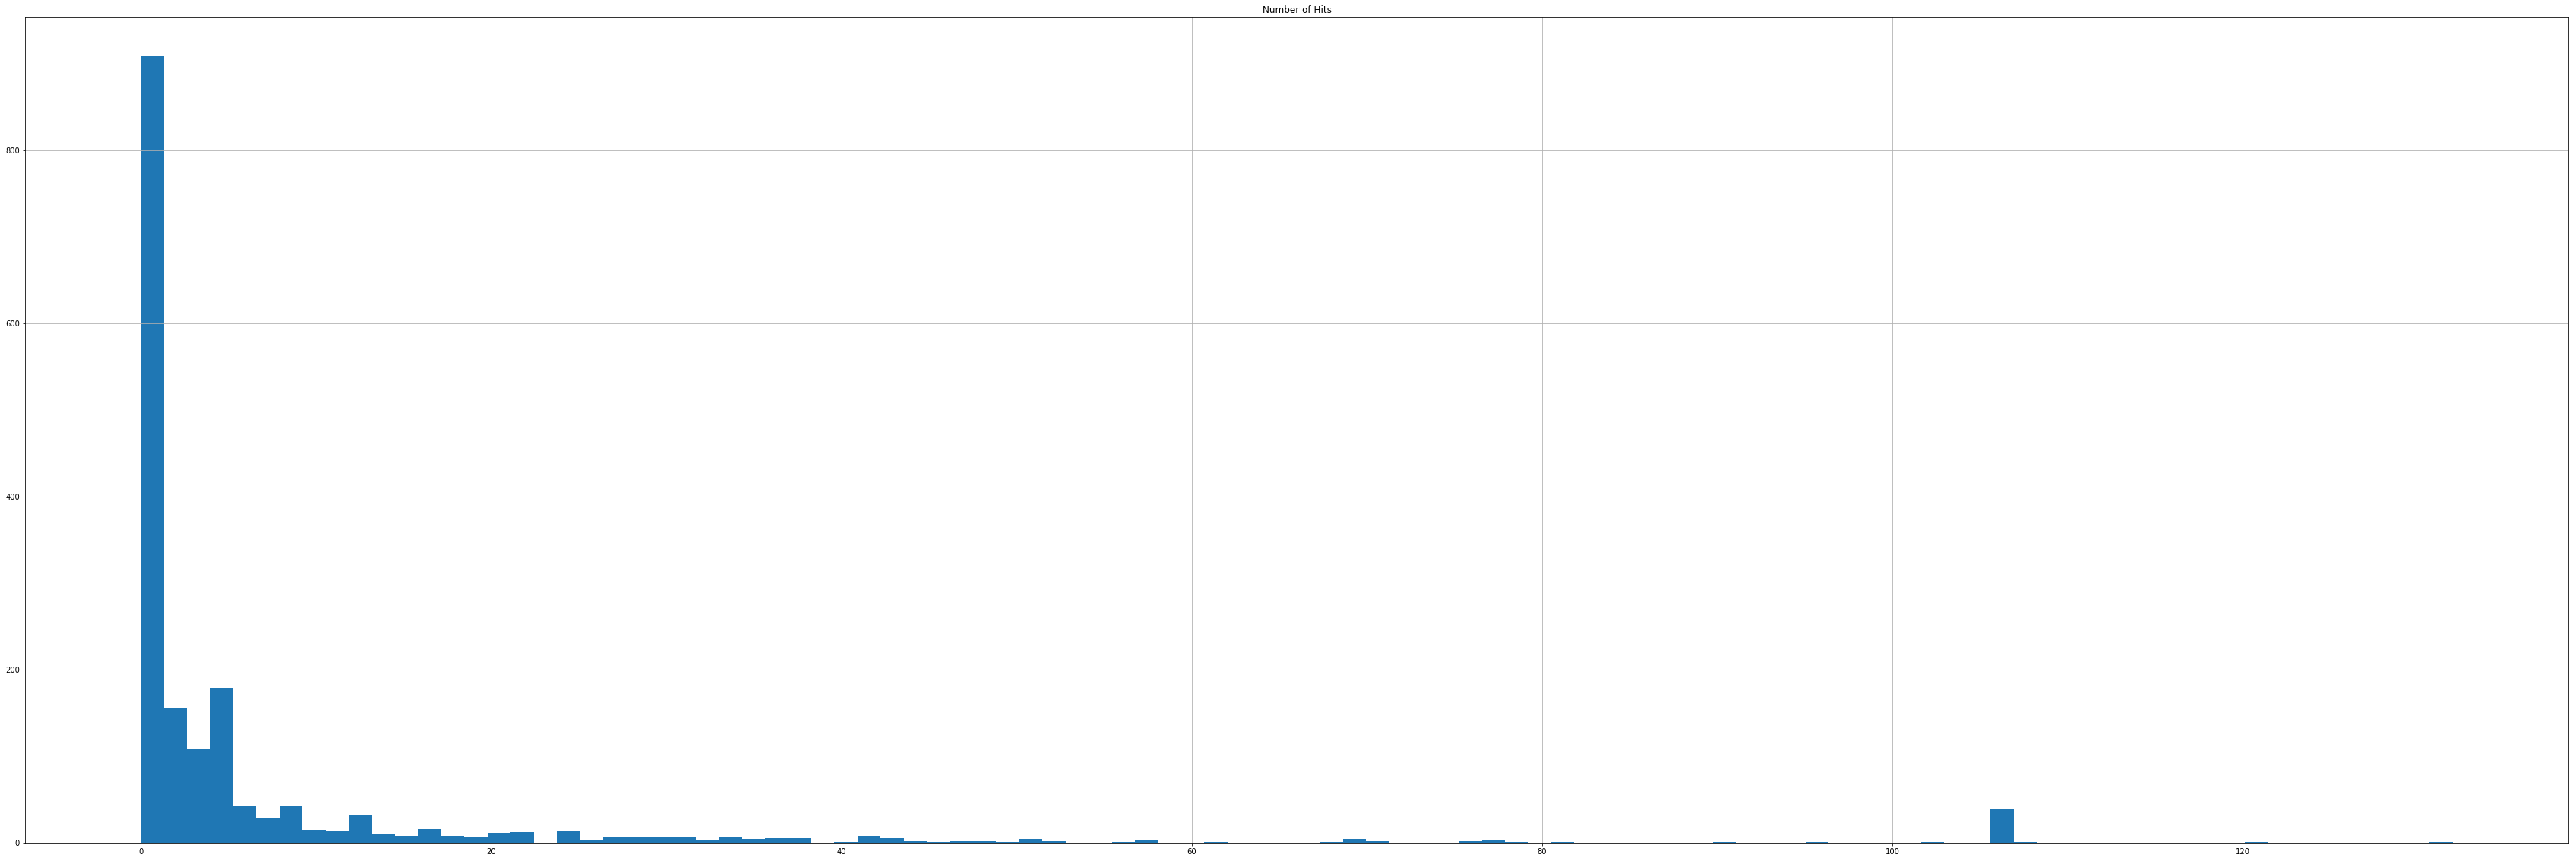

In [169]:
query_check.hist(figsize=(60,20), bins=100)

As we can see, the querying parameters are not good enough. There is substantial repetition for the venues, and almost half of all the queries returned no results. To overcome this problem, we will need to find a way to optimize the querying.

{'meta': {'code': 200, 'requestId': '5e923f330f5968002675861d'},
 'response': {'headerLocation': 'Coeymans',
  'headerFullLocation': 'Coeymans',
  'headerLocationGranularity': 'city',
  'totalResults': 5,
  'suggestedBounds': {'ne': {'lat': 42.484700009000015,
    'lng': -73.78552043672376},
   'sw': {'lat': 42.46669999099999, 'lng': -73.80987956327625}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4c13c39377cea593095ecf60',
       'name': "Yanni's Too",
       'location': {'address': '16 Marina Dr',
        'lat': 42.47439877591863,
        'lng': -73.78983604045717,
        'labeledLatLngs': [{'label': 'display',
          'lat': 42.47439877591863,
          'lng': -73.78983604045717}],
        'distance': 661,
        'postalCode': '12045',
        'cc': 'US',
   

In [79]:
#Checking the Querying

FS_query_host['FourSquare'][3]['meta']['code']

200

In [38]:
#Saving the DF as CVS to the Project

project.save_data("RAW_QUERY.json", FS_query_host.to_json())

{'file_name': 'RAW_QUERY.json',
 'message': 'File saved to project storage.',
 'bucket_name': 'learningproject-donotdelete-pr-ivxdtjkpbb2hvo',
 'asset_id': '3091e225-fe44-4ff3-bc52-be9952f630aa'}

In [39]:
FS_query_host2 = pd.read_json(project.get_file("RAW_QUERY.json"))

In [41]:
FS_query_host2['FourSquare'][0]

{'meta': {'code': 200, 'requestId': '5e9330319da7ee001bf24251'},
 'response': {'warning': {'text': "There aren't a lot of results near you. Try something more general, reset your filters, or expand the search area."},
  'headerLocation': 'Coeymans',
  'headerFullLocation': 'Coeymans',
  'headerLocationGranularity': 'city',
  'totalResults': 1,
  'suggestedBounds': {'ne': {'lat': 42.465100009, 'lng': -73.9155242494},
   'sw': {'lat': 42.447099991, 'lng': -73.9398757506}},
  'groups': [{'type': 'Recommended Places',
    'name': 'recommended',
    'items': [{'reasons': {'count': 0,
       'items': [{'summary': 'This spot is popular',
         'type': 'general',
         'reasonName': 'globalInteractionReason'}]},
      'venue': {'id': '4f00c8990e618ea7678b4000',
       'name': 'Secret Alcove',
       'location': {'address': 'Alcove',
        'lat': 42.4551444968,
        'lng': -73.9310078687,
        'labeledLatLngs': [{'label': 'display',
          'lat': 42.4551444968,
          'lng':

In [33]:
#Defining Functions that will help obtain data from Foursquare

#Function to return the 'venue type' from each query result

def get_category_type(row):
    try:
        categories_list = row['categories']
    except:
        categories_list = row['venue.categories']
        
    if len(categories_list) == 0:
        return None
    else:
        return categories_list[0]['name']

#Function to return all nearby venues to a location
    
def getNearbyVenues(names, latitudes, longitudes, radius, limit=50):
    
    venues_list=[] #Initialize the container
    
    for name, lat, lng in zip(names, latitudes, longitudes):
        
        print(name)
            
        # Assemble the URL for endpoint request
        url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            lat, 
            lng, 
            radius, 
            limit)
            
        # make the GET request
        results = requests.get(url).json()["response"]['groups'][0]['items']
        
        # return only relevant information for each nearby venue
        venues_list.append([(
            name, 
            lat, 
            lng, 
            v['venue']['name'], 
            v['venue']['location']['lat'], 
            v['venue']['location']['lng'],  
            v['venue']['categories'][0]['name']) for v in results])

    nearby_venues = pd.DataFrame([item for venue_list in venues_list for item in venue_list])
    nearby_venues.columns = ['Neighborhood', 
                  'Neighborhood Latitude', 
                  'Neighborhood Longitude', 
                  'Venue', 
                  'Venue Latitude', 
                  'Venue Longitude', 
                  'Venue Category']
    
    return(nearby_venues)

In [34]:
url = 'https://api.foursquare.com/v2/venues/explore?&client_id={}&client_secret={}&v={}&ll={},{}&radius={}&limit={}'.format(
            CLIENT_ID, 
            CLIENT_SECRET, 
            VERSION, 
            42.4561, 
            -73.9277, 
            3000, 
            50)

results = requests.get(url).json()

results

{'meta': {'code': 429,
  'errorType': 'quota_exceeded',
  'errorDetail': 'Quota exceeded',
  'requestId': '5e90d3bdbae9a2001bcc8d56'},
 'response': {}}

In [147]:
#Requesting the API and saving the relevant information to a new DF

venues_small_raw_data = getNearbyVenues(names=zip_loc_small['Zip Code'], latitudes=zip_loc_small['Latitude'], longitudes=zip_loc_small['Longitude'], radius=1000) #See function defined above

venues_small_raw_data.head() #Checkpoint

12007


KeyError: 'groups'

In [45]:
#Code example to retrieve files from Project

#zip_loc_small2 = pd.read_csv(project.get_file("zip_loc_small.csv"))

In [185]:
zip_loc_small.head()

,Zip Code,County,Latitude,Longitude
0,12007,Albany,42.4561,-73.9277
1,12009,Albany,42.7063,-74.0193
2,12023,Albany,42.6108,-74.1466
3,12041,Albany,42.5759,-73.9640
4,12045,Albany,42.4757,-73.7977


In [186]:
radius_table = zip_loc_small.copy()

distance_matrix = np.zeros((len(radius_table['Zip Code']), len(radius_table['Zip Code'])))

for i in range(0, len(radius_table['Zip Code']):
        for j in range(0, i):
            distance_matrix[i][j] = dist.query_postal_code(str(pcd[i]), str(pcd[j]))

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [181]:
pcd = zip_loc_small.copy()
pcd.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
pcd['Radius'] = ''

pcd[pcd['County'] == 'Allegany']

,Zip Code,County,Radius
86,14024,Allegany,
87,14029,Allegany,
88,14060,Allegany,
89,14065,Allegany,
90,14437,Allegany,
91,14536,Allegany,
92,14707,Allegany,
93,14708,Allegany,
94,14709,Allegany,
95,14711,Allegany,


In [175]:
#Calculating distances

pcd = zip_loc_small.copy()
pcd.drop(['Latitude', 'Longitude'], axis=1, inplace=True)
pcd['Radius'] = ''

for county in pcd['County'].unique():
    distance_matrix = np.zeros((len(pcd[pcd['County'] == county]), len(pcd[pcd['County'] == county])))
    temp_
    
    for i in range(0, len(pcd[pcd['County'] == county])):
        for j in range(0, i):
            distance_matrix[i][j] = dist.query_postal_code(str(pcd[i]), str(pcd[j]))

#distance_matrix = np.zeros((len(pcd), len(pcd)))

pcd['County'].unique()

array(['Albany', 'Allegany', 'Broome', 'Cattaraugus', 'Cayuga',
       'Chautauqua', 'Chemung', 'Chenango', 'Clinton', 'Columbia',
       'Cortland', 'Delaware', 'Dutchess', 'Essex', 'Franklin', 'Fulton',
       'Genesee', 'Greene', 'Hamilton', 'Herkimer', 'Jefferson', 'Lewis',
       'Livingston', 'Madison', 'Montgomery', 'Niagara', 'Oneida',
       'Onondaga', 'Ontario', 'Orange', 'Orleans', 'Oswego', 'Otsego',
       'Putnam', 'Rensselaer', 'Richmond', 'Rockland', 'Saratoga',
       'Schenectady', 'Schoharie', 'Schuyler', 'Seneca', 'Steuben',
       'St. Lawrence', 'Sullivan', 'Tioga', 'Tompkins', 'Ulster',
       'Warren', 'Washington', 'Wayne', 'Wyoming', 'Yates'], dtype=object)

In [60]:
time0_pgeocode = time.time()

dist = pgeocode.GeoDistance('US')

dist.query_postal_code(pcd[3], pcd[2])

15.443016641141925

In [184]:
import geopy.distance
import time

t0 = time.time()
for i in range(1000):
    coords_1 = [52.2, 21.01]
    coords_2 = [52.40, 16.92]
    dist = geopy.distance.geodesic(coords_1, coords_2).km
    
print("Terminou")
print(time.time()-t0)

Terminou
0.22877931594848633


In [ ]:
radius_table = zip_loc_small.copy()

distance_matrix = np.zeros((len(radius_table['Zip Code']), len(radius_table['Zip Code'])))

In [190]:
import geopy.distance
import time

t0 = time.time()

radius_table = zip_loc_small.copy()

distance_matrix = np.zeros((len(radius_table['Zip Code']), len(radius_table['Zip Code'])))

for i in range(0, len(pcd)):
    for j in range(0, i):
        distance_matrix[i][j] = geopy.distance.geodesic([radius_table['Latitude'][i], radius_table['Longitude'][i]], [radius_table['Latitude'][j], radius_table['Longitude'][j]]).km
        
print("Job complete!")
print(time.time()-t0)

Job complete!
406.27153515815735


In [194]:
distance_matrix

array([[  0.        ,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 28.79264228,   0.        ,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       [ 24.8742235 ,  14.88238478,   0.        , ...,   0.        ,
          0.        ,   0.        ],
       ...,
       [248.85759061, 240.69652431, 230.12166239, ...,   0.        ,
          0.        ,   0.        ],
       [246.66794541, 239.54897997, 228.57140051, ...,   9.30539503,
          0.        ,   0.        ],
       [247.48854003, 241.18046507, 229.90779216, ...,  16.26128663,
          7.16222251,   0.        ]])

In [192]:
distance_matrix2 = np.copy(distance_matrix)

In [200]:
distance_matrix2[distance_matrix2 == 0] = np.NaN
distance_matrix2

array([[         nan,          nan,          nan, ...,          nan,
                 nan,          nan],
       [ 28.79264228,          nan,          nan, ...,          nan,
                 nan,          nan],
       [ 24.8742235 ,  14.88238478,          nan, ...,          nan,
                 nan,          nan],
       ...,
       [248.85759061, 240.69652431, 230.12166239, ...,          nan,
                 nan,          nan],
       [246.66794541, 239.54897997, 228.57140051, ...,   9.30539503,
                 nan,          nan],
       [247.48854003, 241.18046507, 229.90779216, ...,  16.26128663,
          7.16222251,          nan]])

In [227]:
a = np.where(distance_matrix2 == np.nanmin(distance_matrix2))
a[1][0]

977

In [214]:
#Processing the distance matrix

radius_table['Radius'] = ''
radius_table

,Zip Code,County,Latitude,Longitude,Radius
0,12007,Albany,42.4561,-73.9277,
1,12009,Albany,42.7063,-74.0193,
2,12023,Albany,42.6108,-74.1466,
3,12041,Albany,42.5759,-73.9640,
4,12045,Albany,42.4757,-73.7977,
5,12046,Albany,42.4865,-73.9206,
6,12047,Albany,42.7754,-73.7124,
7,12053,Albany,42.7480,-74.1868,
8,12054,Albany,42.6158,-73.8373,
9,12055,Albany,42.6149,-73.9708,


In [215]:
while radius_table['Radius'].isin(['']).any():
    min_value = np.nanmin(distance_matrix2)
    min_args = np.where(distance_matrix2 == np.nanmin(distance_matrix2))
    min_x = min_args[0][0]
    min_y = min_args[1][0]
    
    if radius_table['Radius'][min_x] == '' & radius_table['Radius'][min_y] == '':
        radius_table['Radius'][min_x] = (min_value/2)
        radius_table['Radius'][min_y] = (min_value/2)
        
    elif radius_table['Radius'][min_x] != '' & radius_table['Radius'][min_y] == '':
        radius_table['Radius'][min_y] = (min_value-radius_table['Radius'][min_x])
    elif radius_table['Radius'][min_x] == '' & radius_table['Radius'][min_y] != '':
        radius_table['Radius'][min_x] = (min_value-radius_table['Radius'][min_y])
    else:

A


In [ ]:
result = np.where(arr == 15)